In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from ctapipe.io import EventSource
from ctapipe.visualization import CameraDisplay, ArrayDisplay
from ctapipe.reco import HillasReconstructor
from ctapipe.image import hillas_parameters, tailcuts_clean
from ctapipe.image import brightest_island, number_of_islands
import math
import astropy.units as u
from astropy.coordinates import SkyCoord, AltAz
from ctapipe.coordinates import CameraFrame
from ctapipe.coordinates.utils import altaz_to_righthanded_cartesian


In [ ]:
dl1_file = "Data/gamma-diffuse_with_images_00.dl2.h5"

source = EventSource(
    input_url = dl1_file,
    max_events = None
)
subarray = source.subarray

Table /configuration/simulation/run is missing column None for field run_number of container <class 'ctapipe.containers.SimulationConfigContainer'>. It will be skipped.


#### Mono Reco for all events on tel id 10

In [ ]:
TEL_ID = 10 
mono_events = []

for event in source:

    if TEL_ID not in event.dl1.tel:
        continue

    dl1 = event.dl1.tel[TEL_ID]

    if dl1.image is None:
        continue

    mono_events.append(event)

print(f"Number of mono events for telescope {TEL_ID}: {len(mono_events)}")

Table /dl1/event/telescope/trigger is missing column event_type for field event_type of container <class 'ctapipe.containers.TelescopeTriggerContainer'>. It will be skipped.
Table /simulation/event/subarray/shower is missing column true_starting_grammage for field starting_grammage of container <class 'ctapipe.containers.SimulatedShowerContainer'>. It will be skipped.
Table /dl2/event/subarray/geometry/HillasReconstructor is missing column HillasReconstructor_ang_distance_uncert for field ang_distance_uncert of container <class 'ctapipe.containers.ReconstructedGeometryContainer'>. It will be skipped.
Table /dl1/event/telescope/parameters/tel_035 is missing column hillas_psi_uncertainty for field psi_uncertainty of container <class 'ctapipe.containers.HillasParametersContainer'>. It will be skipped.
Table /dl1/event/telescope/parameters/tel_035 is missing column hillas_transverse_cog_uncertainty for field transverse_cog_uncertainty of container <class 'ctapipe.containers.HillasParameter

Number of mono events for telescope 10: 7570


In [ ]:
mono_events[0].dl1.tel[TEL_ID].image

array([ 1.2, -1.3, -1.1, ...,  0.4, -0.6,  2.7],
      shape=(1855,), dtype=float32)

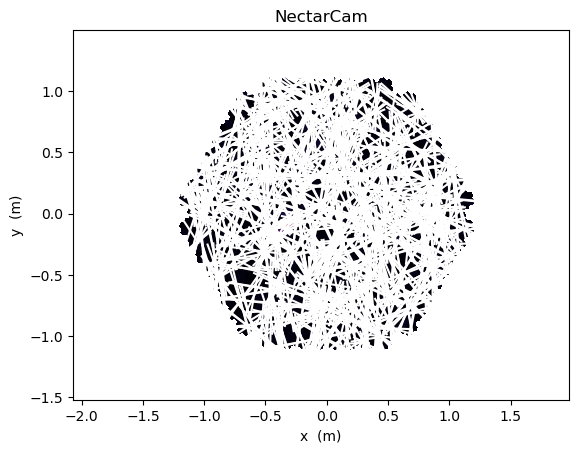

In [ ]:
mono_events
hillas_list = []

for event in mono_events[:500]:
    image = event.dl1.tel[TEL_ID].image
    geometry = subarray.tel[TEL_ID].camera.geometry
    disp = CameraDisplay( 
        geometry,
        image=image,
        show_frame=False
    )
    stdev = np.std(image)
    clean_mask = tailcuts_clean(geometry, image, picture_thresh = 3 * stdev , boundary_thresh = stdev)
    clean_image = image.copy()
    n_islands, island_labels = number_of_islands(geometry, clean_mask)
    brightest_island_mask = brightest_island(n_islands, island_labels, clean_image)
    clean_image[~brightest_island_mask] = 0
    hillas = hillas_parameters(geometry, clean_image)
    hillas_list.append(hillas)
    #disp.overlay_moments(hillas, color="white", with_label = False)


In [ ]:
# Computed psi is camera dependent. First use psi to derive a line in the direction of the semi major axis
# Transform this line to a frame that is camera independent. This is done by correcting for the telescope and array pointing
# First, each derived line is placed on the respective camera frame, then transformed to the sky frame
# Since each telescope is pointing differently, create a pseudo frame aligned with the array pointing and transform the 
# major axis to that frame to completely remove camera frame dependencies 

def corrected_psi(hillas_list, event_list, subarray, tel_id):
    
    psi_corr = []
    psi_pts = []
    altaz = AltAz()

    geometry = subarray.tel[tel_id].camera.geometry
    focal_length = geometry.frame.focal_length
    cam_radius = geometry.guess_radius()

    for hillas, event in zip(hillas_list, event_list):
        
        # Pointing information
        
        tel_pointing = event.monitoring.tel[tel_id].pointing
        array_pointing = event.monitoring.pointing

        telescope_pointing = SkyCoord(az=tel_pointing.azimuth, alt=tel_pointing.altitude, frame=altaz)
        array_pointing_coord = SkyCoord(az=array_pointing.array_azimuth, alt=array_pointing.array_altitude, frame=altaz)

        # Hillas parameters
        cog_x = hillas.x
        cog_y = hillas.y
        psi = hillas.psi.to(u.rad)

        e = 0.1 * cam_radius

        p2_x = cog_x + e * np.cos(psi)
        p2_y = cog_y + e * np.sin(psi)

        # Telescope camera frame

        cam_frame_tel = CameraFrame(telescope_pointing=telescope_pointing, focal_length=focal_length)

        p1_cam = SkyCoord(x=cog_x, y=cog_y, frame=cam_frame_tel)
        p2_cam = SkyCoord(x=p2_x, y=p2_y, frame=cam_frame_tel)

        
        # Transform to altaz 
        p1_altaz = p1_cam.transform_to(altaz)
        p2_altaz = p2_cam.transform_to(altaz)


        # Pseudo camera 
        pseudo_cam = CameraFrame(telescope_pointing=array_pointing_coord, focal_length=focal_length)

        p1_arr = p1_altaz.transform_to(pseudo_cam)
        p2_arr = p2_altaz.transform_to(pseudo_cam)

        dx = (p2_arr.x - p1_arr.x).to_value(u.m)
        dy = (p2_arr.y - p1_arr.y).to_value(u.m)

        psi_pts.append((p1_arr, p2_arr))
        psi_corr.append(np.arctan2(dy, dx) * u.rad)

    return psi_corr, psi_pts


In [44]:
psi_corrected, psi_pts = corrected_psi(hillas_list, mono_events[:len(hillas_list)], subarray, tel_id=TEL_ID)

In [ ]:
# Shower position is taken from the simulation parameters and transformed from altaz to cartesian. 
# The major axis is still in the cam frame. Transform to alt az to project it onto the sky and then to cartesian for easier manipulation
# The vector product of tel pointing vec and the shower pos creates a plane where the major axis vec must ideally lie. 
# Since reconstruction is not ideal, most events will lie approximately parallel to this plane creating a distribution of theta**2

def theta2(axis_points, events, tel_id):

    theta2_vals = []
    altaz = AltAz()

    for (p1, p2), event in zip(axis_points, events):

        # True shower direction from simulation
        shower_dir = SkyCoord(alt=event.simulation.shower.alt, az=event.simulation.shower.az, frame=altaz)
        
        # Converted to cartesian for easier manipulation
        s_vec = altaz_to_righthanded_cartesian(alt=shower_dir.alt, az=shower_dir.az)

        # Major axis points 
        p1_altaz = p1.transform_to(altaz)
        p2_altaz = p2.transform_to(altaz)

        v1 = altaz_to_righthanded_cartesian(alt=p1_altaz.alt, az=p1_altaz.az)
        v2 = altaz_to_righthanded_cartesian(alt=p2_altaz.alt, az=p2_altaz.az)

        axis_vec = (v2 - v1) / np.linalg.norm(v2 - v1)

        # Telescope pointing vector
        tel_pointing = event.monitoring.tel[tel_id].pointing
        tel_vec = altaz_to_righthanded_cartesian(alt=tel_pointing.altitude, az=tel_pointing.azimuth)

        # Plane normal
        n_vec = np.cross(axis_vec, tel_vec)
        n_vec /= np.linalg.norm(n_vec)

        # Angle between shower direction and plane
        angle = np.arcsin( np.abs(np.dot(n_vec, s_vec))) * u.rad

        theta2_vals.append(angle.to(u.deg)**2)

    return u.Quantity(theta2_vals)


In [55]:
thet2 = theta2(psi_pts, mono_events[:len(psi_corrected)], TEL_ID)

(0.0, 40.0)

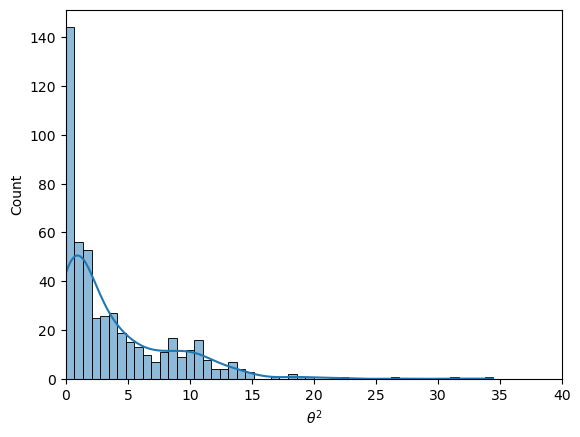

In [57]:
import seaborn as sns
sns.histplot(thet2, kde=True, bins = 50)
plt.xlabel(r"$\theta^2$")
plt.xlim(0,40)